# Oscillation in eeg 

In [1]:
%load_ext autoreload
%autoreload 2

## Imports 

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns
import scipy as sp 
import scipy.fftpack
import numpy as np


warnings.filterwarnings('ignore')

## Variables d'environnements 

In [3]:
sampling_rate = 250
time = 1/sampling_rate # in seconds
unit_time = 's'
start = 1 # in seconds
end = 1.01 

## Lecture du fichier et ajout des colonnes

Text(0.5, 1.0, 'EEG signal')

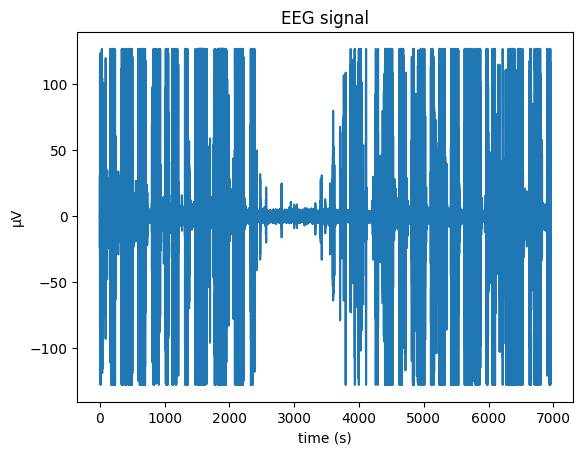

In [4]:
df = pd.read_csv('../../data/EEGArchi13mPFC.txt')
# df = df.iloc[int(start*sampling_rate):int(end*sampling_rate)] # Si on veut ne sélectionner qu'une partie du signal 
df['time'] = df.index * time
df.rename(columns={'0': 'µV'}, inplace=True)
plt.plot(df['time'], df['µV'])
plt.xlabel(f'time ({unit_time})')
plt.ylabel('µV')
plt.title('EEG signal')

## Filtration (passe-bas) du signal par les fréquences inférieurs à 12 Hz 

Text(0, 0.5, 'µVf')

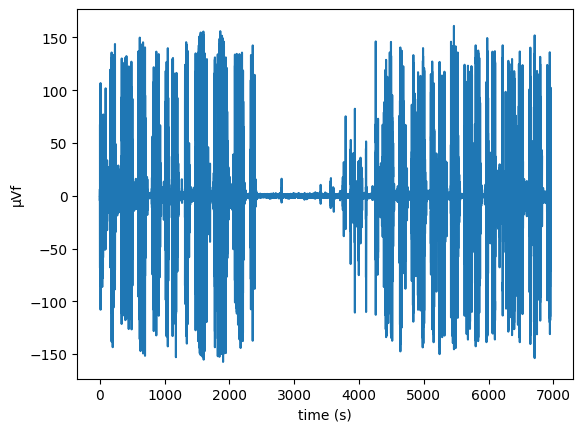

In [5]:
b, a = scipy.signal.iirfilter(4, Wn=12, fs=sampling_rate, btype="low", ftype="butter")
df['µVf'] = scipy.signal.filtfilt(b, a, df['µV'])
plt.plot(df['time'], df['µVf'])
plt.xlabel(f'time ({unit_time})')
plt.ylabel('µVf')

## Calcul de la transformée de fourier sur les valeurs filtrées 

Text(0, 0.5, 'Amplitude')

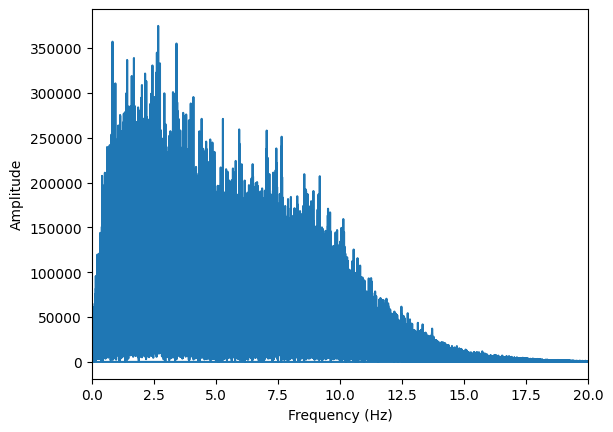

In [6]:
df["amp"] = np.abs(scipy.fftpack.fft(df['µVf'].values))
df["freq"] = scipy.fftpack.fftfreq(df['µVf'].size, d=time)
plt.plot(df["freq"], df["amp"])
plt.xlim(0,20)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

Ici on vois un pic à 10 Hz ce qui correspond à une onde theta 

On ne vois néamoins pas l'onde delta qui est à 4 Hz

/!\ Surement un problème liée aux bruit dans le signal 

## Transformée de fourrier sur les données non filtrées

Text(0.5, 1.0, 'Fourier transform of the EEG signal')

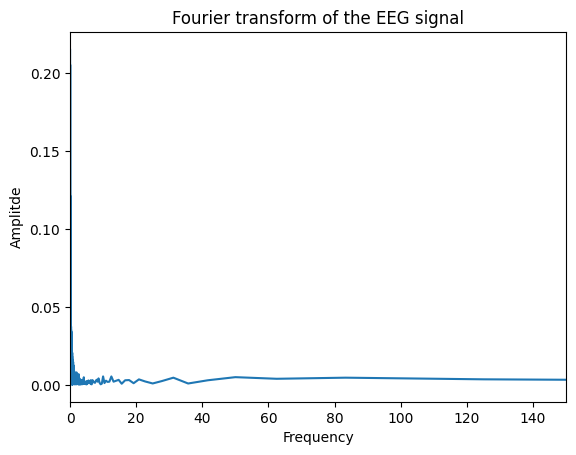

In [7]:
df_f = df.copy()

df_f['amplitude'] = sp.fftpack.fft(df_f['µV'])/len(df_f['µV'])
df_f["freq"] = 1/df_f['time']
plt.plot(df_f['freq'], np.abs(df_f['amplitude']))
plt.xlabel(f'Frequency')
plt.xlim(0, 150)
plt.ylabel('Amplitde')
plt.title('Fourier transform of the EEG signal')

- gamma = 30 Hz 
- Theta = 5-12 Hz

## Essai de créer une heatmap de la fréquence en fonction du temps 

In [8]:
test = sp.signal.cwt(df_f['µV'], sp.signal.morlet2, np.arange(1, 40),dtype="complex128")

In [9]:
len(test), len(test[0]),test[0][0]

(39, 1739499, (0.06578013945583835+0.0044215140216547705j))

Text(0.5, 1.0, 'EEG signal')

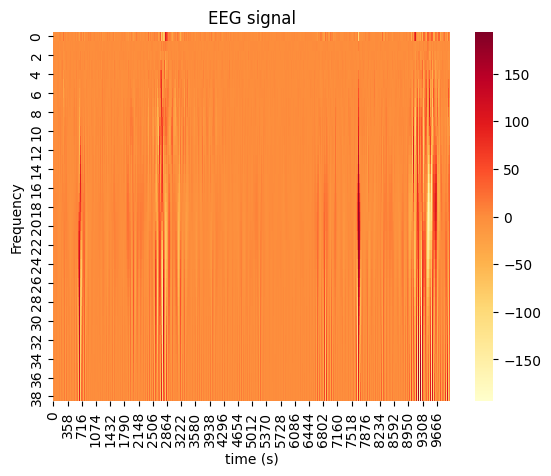

In [10]:
test_df = pd.DataFrame(test)
test_df = test_df.transpose()
test_df.index = df_f['time']
test_df = test_df.iloc[:10_000]
test_df = test_df.to_numpy()
test_df = test_df.real
test_df = test_df.transpose()
fig = plt.figure(figsize=(10, 10), dpi = 100)
sns.heatmap(test_df, cmap="YlOrRd")
plt.xlabel(f'time ({unit_time})')
plt.ylabel('Frequency')
plt.title('EEG signal')
plt.savefig("figures/")
# ax = plt.gca()
# ax.set_ylim(8,20)

## Tests BLP non fonctionnel 

In [11]:
res = []
for i in range(len(test)):
    a = np.array(test[i]) 
    a = np.float32(a)
    a = a.real
    res.append(a)
test_2 = sp.signal.cwt(a, sp.signal.morlet2, np.arange(1, 40),dtype="complex128")

# test_2 = pd.DataFrame(test_2)
# test_2 = test_2.transpose()
# test_2.index = df_f['time']
# test_2 = test_2.iloc[:10_000]
# test_2 = test_2.to_numpy()
# test_2 = test_2.real
# test_2 = test_2.transpose()
# sns.heatmap(test_2, cmap="YlOrRd")

In [12]:
test = sp.signal.cwt(res, sp.signal.morlet2, np.arange(1, 40),dtype="complex128")
test_df = pd.DataFrame(test)
test_df

ValueError: volume and kernel should have the same dimensionality

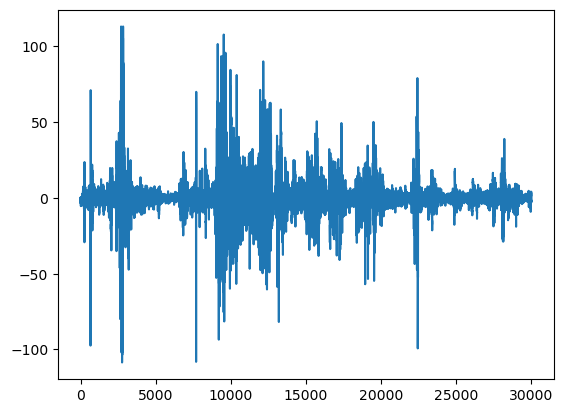

In [13]:
plt.plot(test[0][:30000])

In [14]:
# Create a function to get the band limited power of a signal 
def get_band_power(df, band, sampling_rate):
    # get the fourier transform of the signal 
    df['amplitude'] = sp.fftpack.fft(df['µV'])/len(df['µV'])
    # get the frequency of the signal 
    df["freq"] = 1/df['time']
    # get the power of the signal 
    df['power'] = np.abs(df['amplitude'])**2
    # get the band limited power 
    band_power = df.loc[(df['freq'] >= band[0]) & (df['freq'] <= band[1]), 'power'].sum()
    return band_power

get_band_power(df, [0, 4], sampling_rate)

527.7500739544367